In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import scipy.stats as st

from statsmodels.graphics.mosaicplot import mosaic

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [3]:
RANDOM_STATE = 26

# Predictive Maintenance (part 1) - Machining Process

## Abstract

The project investigates two cases of predictive maintenance - one related to machining parts and the other - failures on the air production unit of metro trains in Porto, Portugal.

The two data sets are similar: they both contain time series and have low number of failures making the classes imbalanced. The main scope of the project is related to data-science: pre-process the data, look for patterns, make hypothesis and test them. In addition, an attempt to model the first data set is made. Also, several other topics such as signal analysis, smoothing, and (domain) feature engineering are investigated. 

## Introduction

Machines and equipment must be periodically inspected and serviced. Parts are replaced and consumables - replenished. One strategy is to repair the equipment only after a breakdown occurs; this is called **corrective / reactive maintenance**. If, on the other hand, this maintenance is done in a scheduled points in time (say every month) we call it **preventive / scheduled maintenance**.

Both strategies have drawbacks (e.g. over-maintenance: equipment gets maintained whether it needs it or not). A more scientific alternative is to determine the condition of the machine and forecast the time left till the next failure; this is called **predictive maintenance**.

## 1. Data

### Description

The first data set contains data from a parts-machining process. It is one of the few suitable datasets on the topic that I have managed to find. The data is not measured from an actual process, it was artificially generated using a set of rules. Here are the [description](https://archive.ics.uci.edu/ml/datasets/AI4I+2020+Predictive+Maintenance+Dataset), [paper](https://ieeexplore.ieee.org/document/9253083), and [data](https://archive.ics.uci.edu/ml/machine-learning-databases/00601/ai4i2020.csv).

### Paths

In [4]:
INPUT_DATA = "data/ai4i2020.csv"
META_DATA = "data/machine_meta_data.xlsx"

### Meta data

Meta data (e.g. columns descriptions) is prepared and stored in an external excel file.

In [5]:
machine_meta = pd.read_excel(META_DATA, sheet_name="features")
machine_meta.head()

,original_name,group,description_short,keep,new_name,description_long,Comment
0,UDI,na,observation identifier,no,NaN,NaN,NaN
1,Product ID,product,product numberc (type + unique serial number),no,NaN,Product number. Consist of the type and unique...,NaN
2,Type,product,"product type (H, M, L)",yes,product_type,NaN,NaN
3,Air temperature [K],process,ambient air temperature in K,yes,air_temperature,NaN,Convert from K to C
4,Process temperature [K],process,process temperature in K,yes,process_temperature,NaN,Convert from K to C


### Columns

The original columns are read from the meta data. A `group` column is used for easier filtering later. Full description of the variables and how they are generated is in the data description (see link above).

In [6]:
original_columns = machine_meta[["original_name", "group", "description_short"]]
original_columns

,original_name,group,description_short
0,UDI,na,observation identifier
1,Product ID,product,product numberc (type + unique serial number)
2,Type,product,"product type (H, M, L)"
3,Air temperature [K],process,ambient air temperature in K
4,Process temperature [K],process,process temperature in K
5,Rotational speed [rpm],process,motor speed in rpm
6,Torque [Nm],process,motor torque in Nm
7,Tool wear [min],process,accumulated machining tool wear in min
8,Machine failure,failure,flag that any of the 5 failures has occurred
9,TWF,failure,tool wear failure


## 2. Clean and tidy

### Read

In [7]:
machine = pd.read_csv(INPUT_DATA)

### Get to know

In [8]:
machine.columns

Index(['UDI', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF',
       'RNF'],
      dtype='object')

In [9]:
machine.dtypes

UDI                          int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Machine failure              int64
TWF                          int64
HDF                          int64
PWF                          int64
OSF                          int64
RNF                          int64
dtype: object

In [10]:
machine.shape

(10000, 14)

In [11]:
machine.describe().T

,count,mean,std,min,25%,50%,75%,max
UDI,10000.0,5000.50000,2886.895680,1.0,2500.75,5000.5,7500.25,10000.0
Air temperature [K],10000.0,300.00493,2.000259,295.3,298.30,300.1,301.50,304.5
Process temperature [K],10000.0,310.00556,1.483734,305.7,308.80,310.1,311.10,313.8
Rotational speed [rpm],10000.0,1538.77610,179.284096,1168.0,1423.00,1503.0,1612.00,2886.0
Torque [Nm],10000.0,39.98691,9.968934,3.8,33.20,40.1,46.80,76.6
Tool wear [min],10000.0,107.95100,63.654147,0.0,53.00,108.0,162.00,253.0
Machine failure,10000.0,0.03390,0.180981,0.0,0.00,0.0,0.00,1.0
TWF,10000.0,0.00460,0.067671,0.0,0.00,0.0,0.00,1.0
HDF,10000.0,0.01150,0.106625,0.0,0.00,0.0,0.00,1.0
PWF,10000.0,0.00950,0.097009,0.0,0.00,0.0,0.00,1.0


### Select features

2 columns are dropped as they do not carry useful information.

In [12]:
columns_to_drop = machine_meta[machine_meta.keep == "no"].original_name
columns_to_drop

0           UDI
1    Product ID
Name: original_name, dtype: object

In [13]:
columns_to_keep = machine_meta[machine_meta.keep == "yes"].original_name
columns_to_keep

2                        Type
3         Air temperature [K]
4     Process temperature [K]
5      Rotational speed [rpm]
6                 Torque [Nm]
7             Tool wear [min]
8             Machine failure
9                         TWF
10                        HDF
11                        PWF
12                        OSF
13                        RNF
Name: original_name, dtype: object

In [14]:
machine = machine[columns_to_keep]

### Check for missing values

No missing values. This is expected as the data is synthetic (generated by an algorithm).

In [15]:
machine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Type                     10000 non-null  object 
 1   Air temperature [K]      10000 non-null  float64
 2   Process temperature [K]  10000 non-null  float64
 3   Rotational speed [rpm]   10000 non-null  int64  
 4   Torque [Nm]              10000 non-null  float64
 5   Tool wear [min]          10000 non-null  int64  
 6   Machine failure          10000 non-null  int64  
 7   TWF                      10000 non-null  int64  
 8   HDF                      10000 non-null  int64  
 9   PWF                      10000 non-null  int64  
 10  OSF                      10000 non-null  int64  
 11  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 937.6+ KB


In [16]:
machine.isna().sum()

Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64

### Rename columns

New names are defined in the excel meta data file.

In [17]:
new_column_names = machine_meta[machine_meta.keep == "yes"].new_name
new_column_names.name = ""
machine.columns = new_column_names
machine.head()

,product_type,air_temperature,process_temperature,speed,torque,tool_wear,failure_any,failure_toolwear,failure_heatdissipation,failure_power,failure_overstrain,failure_random
0,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


### Convert types

- Convert the two temperatures in the dataset from $K$ to $C$.
- Convert `product_type` to `category.`

In [18]:
machine[["air_temperature", "process_temperature"]] = machine[["air_temperature", "process_temperature"]] - 273.15

In [19]:
machine.product_type = machine.product_type.astype("category")

### Create new features

#### Elapsed time
Total duration of machining calculated by adding up all `tool_wear` durations.

In [20]:
def get_elapsed_time():
    elapsed_time_data = [0]
    start_duration = 0

    for t in machine.tool_wear[1:]:
        if t == 0:
            start_duration = elapsed_time_data[-1]
        elapsed_time_data.append(t + start_duration)

    return elapsed_time_data

In [21]:
machine["elapsed_time"] = pd.to_timedelta(get_elapsed_time(), unit="minutes")

In [22]:
machine.head().elapsed_time

0   0 days 00:00:00
1   0 days 00:03:00
2   0 days 00:05:00
3   0 days 00:07:00
4   0 days 00:09:00
Name: elapsed_time, dtype: timedelta64[ns]

#### Motor power
Calculated motor power. Shaft angular speed expressed in $rad / sec$, T expressed in $N/m$.

In [23]:
# Convert speed from rpm to rad
speed_rad = machine.speed * 0.104719755

In [24]:
machine["power"] = speed_rad * machine.torque

In [25]:
machine.head().power

0    6951.590552
1    6826.722716
2    7749.387534
3    5927.504652
4    5897.816602
Name: power, dtype: float64

### Reorder columns

In [26]:
machine = machine[[
    "elapsed_time",
    "product_type",
    "air_temperature",
    "process_temperature",
    "speed",
    "torque",
    "power",
    "tool_wear",
    "failure_any",
    "failure_toolwear",
    "failure_heatdissipation",
    "failure_power",
    "failure_overstrain",
    "failure_random",
]]

### Dimensionality reduction

Let's investigate the option to reduce the number of features using Principal Component Analysis (PCA). Some comment on how the features were selected:
- `tool_wear` is the cumulative lifetime in min of the tool before it is replaced. Each of the three product types H, L, M add up a certain number of minutes (the same every time). Thus, `tool_wear` is a derived feature and is not included.
- `elapsed_time` is derived from `tool_wear`, not included.
- `power` is derived from `speed` and `torque`, not included.

Observations:
- The first 3 principle components account for >90% of the total variance.

Conclusion: PCA is not needed as the number of original features is low. Continue to use the original features.

In [27]:
machine_features = machine[[
    "product_type",
    "air_temperature",
    "process_temperature",
    "speed",
    "torque",
]]

machine_with_dummies = pd.get_dummies(machine_features, columns=["product_type"])

scaler = MinMaxScaler()
machine_features_scaled = scaler.fit_transform(machine_with_dummies)

pca = PCA().fit(machine_features_scaled)

In [28]:
total_variance = np.sum(pca.singular_values_ ** 2)
explained_variance = np.array([(x ** 2 / total_variance) for x in pca.singular_values_])
cumulative_explained_variance = np.cumsum(explained_variance)

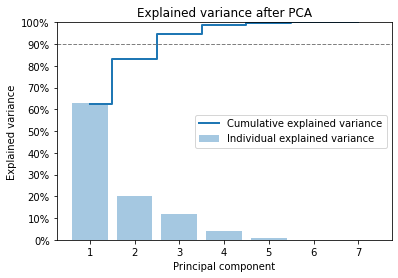

In [29]:
fig, ax = plt.subplots()

x = np.arange(1, 1 + len(explained_variance))

# Explained variance
plot1 = ax.bar(
    x=x,
    height=explained_variance.round(2),
    align='center',
    label='Individual explained variance',
    alpha=0.4)

# Cumulative explained variance
plot2 = ax.step(
    x=x,
    y=cumulative_explained_variance,
    where='mid',
    label='Cumulative explained variance',
    linewidth=2,
)

# 90% line
plt.axhline(0.9, linestyle="--", linewidth=1, color="gray")

# x axis
plt.xlabel('Principal component')

# y axis
plt.ylabel('Explained variance')
plt.yticks(ticks=np.arange(0, 1.1, 0.1))
plt.ylim((0, 1))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

plt.title("Explained variance after PCA")
plt.legend()
plt.show()

## 3. Explore

### Create column groups

Variables are grouped for easier filtering during EDA.

In [30]:
all_columns = "\n".join([f'    "{x}", ' for x in machine.columns])
print(f"List of all columns:\n{all_columns}")

List of all columns:
    "elapsed_time", 
    "product_type", 
    "air_temperature", 
    "process_temperature", 
    "speed", 
    "torque", 
    "power", 
    "tool_wear", 
    "failure_any", 
    "failure_toolwear", 
    "failure_heatdissipation", 
    "failure_power", 
    "failure_overstrain", 
    "failure_random", 


In [31]:
failure_modes = [
    "failure_toolwear",
    "failure_heatdissipation",
    "failure_power",
    "failure_overstrain",
    "failure_random",
]

continuous_variables = [
    "air_temperature",
    "process_temperature",
    "speed",
    "torque",
    "power",
]

variables_for_correlation = [
    "product_type",
    "air_temperature",
    "process_temperature",
    "speed",
    "torque",
    "power",
    "tool_wear",
]

variables_for_time_series = [
    "product_type",
    "air_temperature",
    "process_temperature",
    "speed",
    "torque",
    "power",
    "tool_wear",
    "failure_any",
    "failure_toolwear",
    "failure_heatdissipation",
    "failure_power",
    "failure_overstrain",
    "failure_random",
]

### Proportions
#### Of all parts

Observations:
- Most produced parts are from type `L`.
- Failure occurred for roughly 3% of the total parts.

In [32]:
def pie_plot_categories(data, title):
    plt.pie(data, labels=data.index, autopct="%.1f")
    plt.title(title)
    plt.show()

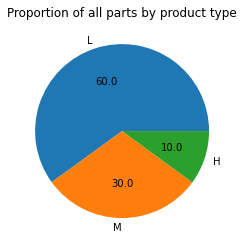

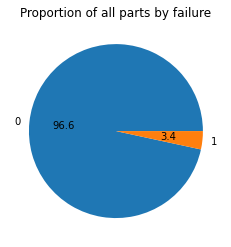

In [33]:
by_product_type = machine.product_type.value_counts()
pie_plot_categories(by_product_type, "Proportion of all parts by product type")

by_failure = machine.failure_any.value_counts()
pie_plot_categories(by_failure, "Proportion of all parts by failure")

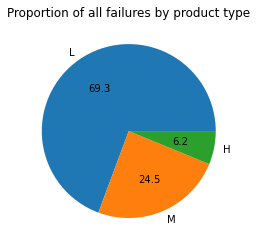

In [34]:
by_product_type = machine[machine.failure_any == 1].product_type.value_counts()
pie_plot_categories(
    by_product_type, "Proportion of all failures by product type")

#### Of all failures by product type

Observations:
- The better the quality, the smaller the proportion of failures (`H` = high, `M` = medium, `L` = low quality).

In [35]:
all_failures_by_product = machine[machine.failure_any == 1].product_type.value_counts()
total_volume_by_product = machine.product_type.value_counts()

failure_pct = 100 * all_failures_by_product / total_volume_by_product
ok_pct = 100 - failure_pct

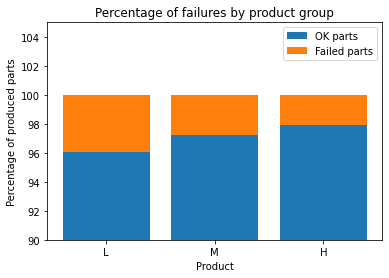

In [36]:
fig, ax = plt.subplots()

labels = machine.product_type.value_counts().index
ax.bar(labels, ok_pct, label='OK parts')
ax.bar(labels, failure_pct, bottom=ok_pct, label='Failed parts')

ax.set_ylabel('Percentage of produced parts')
ax.set_ylim(bottom=90)

plt.xlabel("Product")
ax.set_title('Percentage of failures by product group')
ax.legend()
plt.show()

The observations above can be better seen from a mosaic plot.

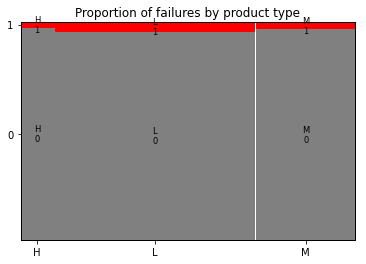

In [37]:
data = machine.groupby(["product_type", "failure_any"]).size()

def props(pair): 
    return {'color': 'red' if pair[1] == '1' else 'gray', }

mosaic(data=data, properties=props, title="Proportion of failures by product type")
plt.show()

#### Between failure modes

Observations:
- Heat, power and over-strain account for 80% of the total failures.

In [38]:
occurrences = {}
for failure_mode in failure_modes:
    occurrences[failure_mode] = machine[failure_mode].value_counts()[1]
occurrences = pd.Series(occurrences)

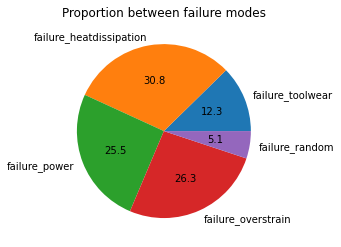

In [39]:
pie_plot_categories(occurrences, "Proportion between failure modes", )

#### Between failure modes by product type

Observations:
- Overall, each product has different typical failure modes.
- `failure_overstrain` proportion for `L` is much higher than the other two products.

In [40]:
# Generate data

all_occurrences = {}
for product_type in list("LMH"):
    occurrences = {}
    machine_by_prouduct_type = machine[machine.product_type == product_type]
    for failure_mode in failure_modes:
        occurrences[failure_mode] = machine_by_prouduct_type[failure_mode].value_counts()[
            1]

    occurrences = pd.Series(occurrences)
    occurrences_relative = occurrences / occurrences.sum()
    all_occurrences[product_type] = occurrences_relative

all_occurrences = pd.DataFrame(all_occurrences).T
all_occurrences

,failure_toolwear,failure_heatdissipation,failure_power,failure_overstrain,failure_random
L,0.096154,0.292308,0.226923,0.334615,0.050000
M,0.160920,0.356322,0.356322,0.103448,0.022989
H,0.269231,0.307692,0.192308,0.076923,0.153846


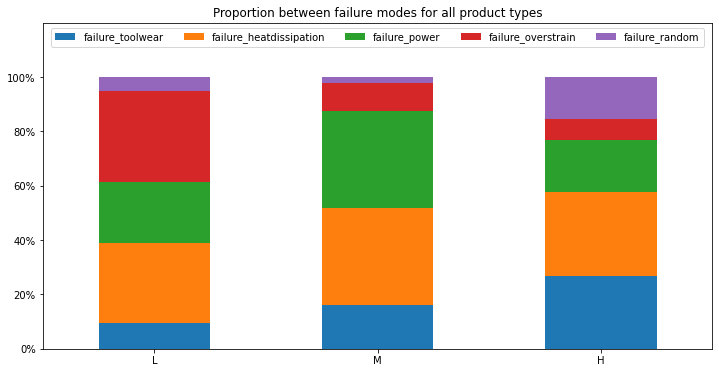

In [41]:
# Plot data

all_occurrences.plot.bar(stacked=True, figsize=(12, 6))

plt.ylim(top=1.2)
plt.yticks(np.arange(0, 1.1, 0.2))
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

plt.xticks(rotation=0)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1), ncol=5)

plt.title("Proportion between failure modes for all product types")
plt.show()

### Time series

#### Smoothing

Smoothing is the procedure of removing the noise from data. The aim is to identify patters and trends more easily.

There are multiple smoothing techniques. One of the most common algorithms is the moving or rolling average. In Pandas, it is implemented in the `pandas.DataFrame.rolling` method. It is part of the [windowing operations](https://pandas.pydata.org/docs/user_guide/window.html). Another method suggested in [this article](https://www.mikulskibartosz.name/smoothing-time-series-in-pandas/) is the exponentially weighted average. Below is a comparison between the two smoothing algorithms.

**Conclusion:** `.rolling(window=10, center=True).mean()` to be used in the subsequent analysis. It seems to keep the overall trends.

**Note:** The x axis used is the `elapsed_time` column. Note that we extract the hours from the `timedelta64` values. However, we can not simply used `.astype('timedelta64[h]')` as it will assign the same `x` value for multiple rows effectively lowering the resolution. We must use `astype('timedelta64[s]') / (60 * 60)`.

In [42]:
# [
#     machine.head(2).elapsed_time,
#     machine.head(2).elapsed_time.astype('timedelta64[h]'),
#     machine.head(2).elapsed_time.astype('timedelta64[s]') / (60 * 60)
# ]

In [43]:
# Generate smooth data
columns_to_smooth = [
    "air_temperature",
    "process_temperature",
    # 'speed',
    # 'torque',
    # 'power',
]

machine_subset = machine[:300]

# raw
machine_raw = machine_subset[columns_to_smooth]

# moving average
machine_moving_average_5 = machine_raw.rolling(window=5, center=True).mean()
machine_moving_average_10 = machine_raw.rolling(window=10, center=True).mean()

# exponentially weighted window
machine_ewm_5 = machine_raw.ewm(span=5).mean()
machine_ewm_10 = machine_raw.ewm(span=10).mean()

# x axis (for plotting)
x = machine_subset.elapsed_time.astype("timedelta64[s]") / (60 * 60)

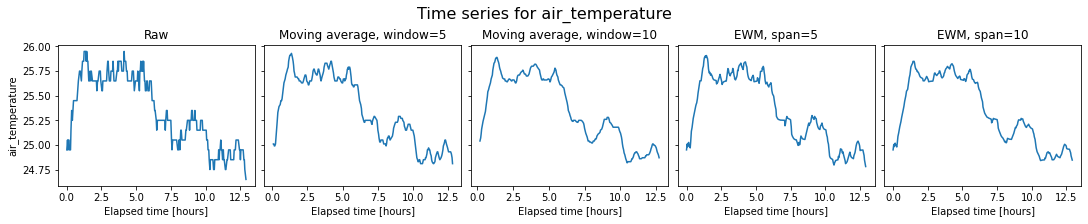

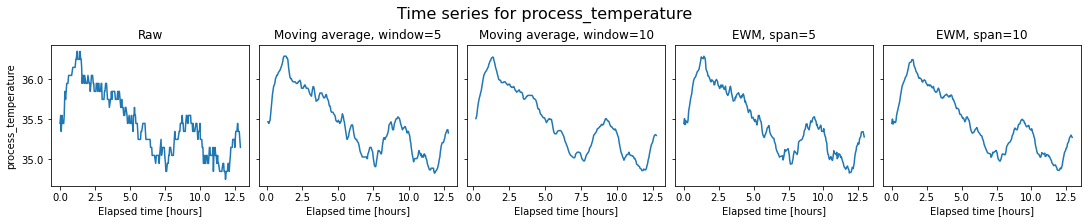

In [44]:
# Plot
dfs = [
    machine_raw,
    machine_moving_average_5,
    machine_moving_average_10,
    machine_ewm_5,
    machine_ewm_10,
]

titles = [
    "Raw",
    "Moving average, window=5",
    "Moving average, window=10",
    "EWM, span=5",
    "EWM, span=10",
]

for column in columns_to_smooth:
    fig, axs = plt.subplots(1, 5, constrained_layout=True, sharey=True, figsize=(15, 3))

    axs[0].set_ylabel(column)

    for ax, df, title in zip(axs, dfs, titles):
        ax.plot(x, df[column])
        ax.set_xlabel("Elapsed time [hours]")
        ax.set_title(title)
        # ax.set_ylabel(column)

    fig.suptitle(f"Time series for {column}", fontsize=16)

#### Individual

##### Beginning

Let's start by plotting the data for the first 1000 parts.

Observations:
- No apparent patters. Continue with plotting the complete data.

In [45]:
columns_to_smooth = [
    "air_temperature",
    "process_temperature",
    "speed",
    "torque",
    "power",
]

columns_not_to_smooth = [
    "tool_wear",
    "failure_any",
    "failure_toolwear",
    "failure_heatdissipation",
    "failure_power",
    "failure_overstrain",
    "failure_random",
]

titles = [
    "Raw",
    "Moving average, window=10",
]

In [46]:
def generate_plot_data(start, end):
    """
    Generates data frames for plotting containing both raw and 
    smoothed time series depending on the column.

    `start`, `end`: range of rows. Used to filter a subset of the original data.

    `machine_raw_combined`: all raw (unfiltered) time series, as columns
    `machine_moving_average_10`: smoothed version of some time series, as columns
    """
    machine_subset = machine[start:end]

    machine_raw = machine_subset[columns_to_smooth]
    machine_moving_average_10 = machine_raw.rolling(window=10, center=True).mean()

    machine_raw_not_smoothed = machine_subset[columns_not_to_smooth]
    machine_raw_combined = pd.concat([machine_raw, machine_raw_not_smoothed], axis=1)

    dfs = [
        machine_raw_combined,
        machine_moving_average_10,
    ]

    x = machine_subset.elapsed_time.astype('timedelta64[s]') / (60 * 60)

    return dfs, x

In [47]:
def plot_multiple_time_series(dfs, x, width=4, height=3):
    """
    Plots time series for all columns of the data frames in `dfs`.

    `dfs`: dataframes with raw or smoothed data in each column
    `x`: values for the x axis
    `width`: the width of a single plot
    `height`: the height of a single plot
    """
    n_plots = len(dfs)
    columns = dfs[0].columns
    figsize = (n_plots * width, height)

    for column in columns:
        fig, axs = plt.subplots(1, n_plots, constrained_layout=True, sharey=True, figsize=figsize)

        axs[0].set_ylabel(column)

        for ax, df, title in zip(axs, dfs, titles):
            if column not in df.columns:
                continue
            ax.plot(x, df[column])
            ax.set_xlabel("Elapsed time [hours]")
            ax.set_title(title)

        fig.suptitle(f"Time series for {column}", fontsize=12)

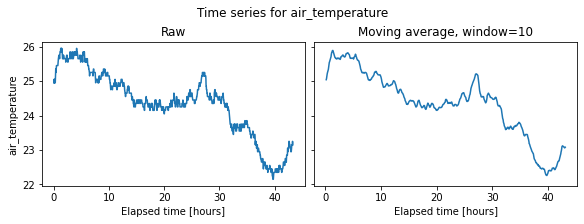

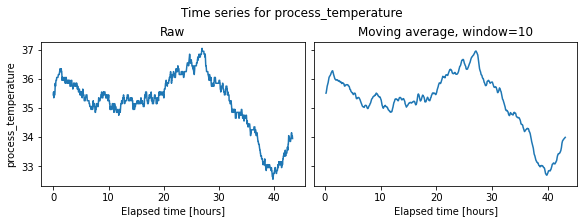

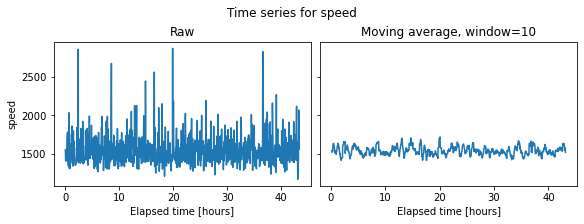

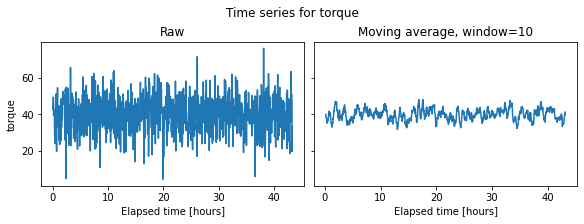

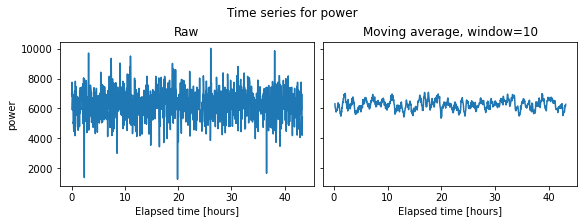

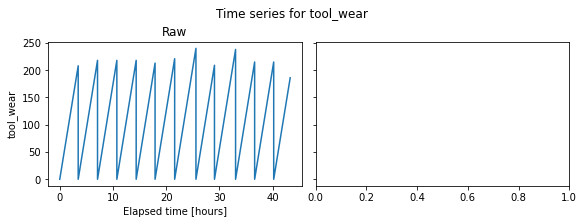

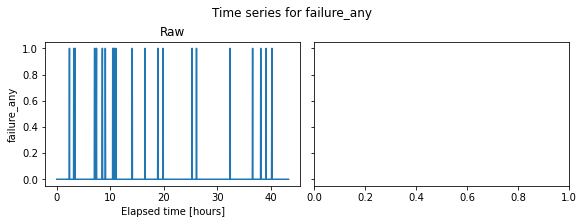

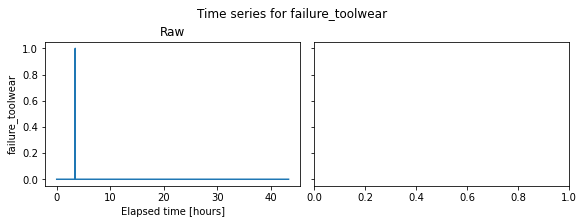

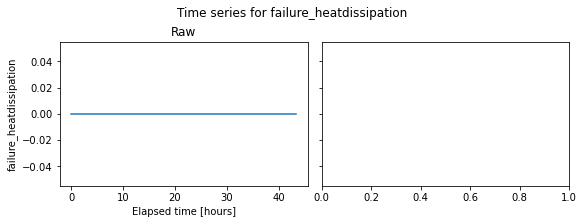

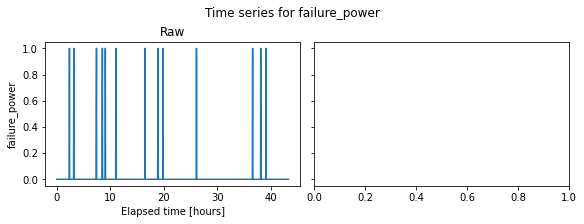

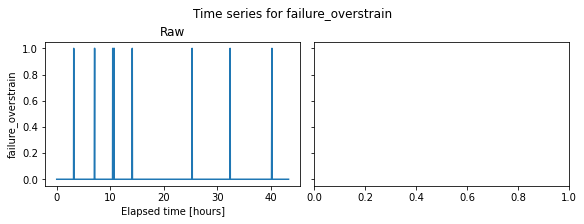

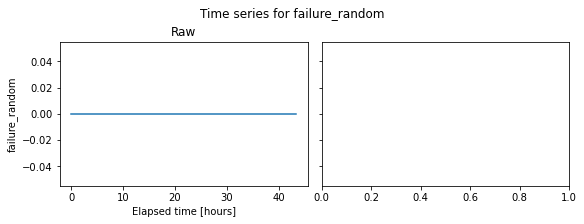

In [48]:
dfs, x = generate_plot_data(0, 1000)
plot_multiple_time_series(dfs, x)

##### Overall

Plots for the complete duration, all parts.

Observations:
- The two temperatures increase at approx. 200th hour. The heat dissipation failures are concentrated at the same period.
- The random failures are in two distinct periods.

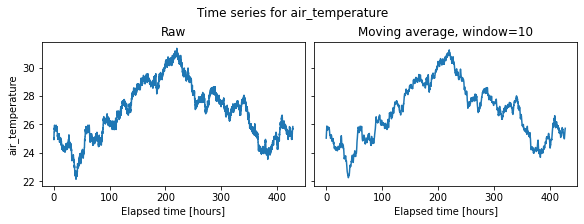

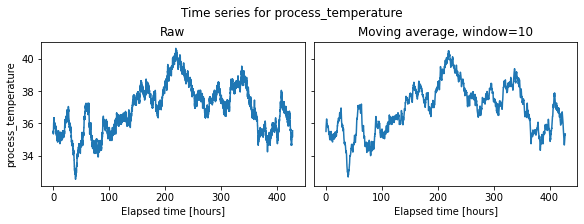

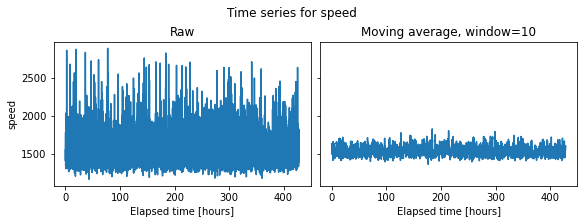

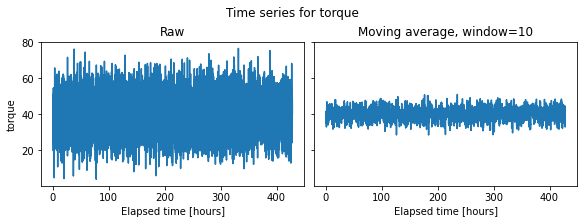

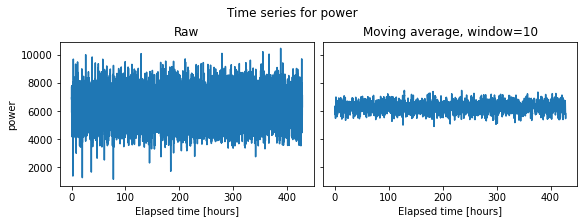

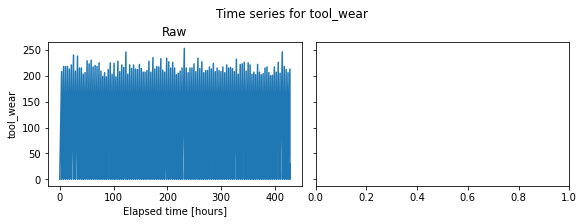

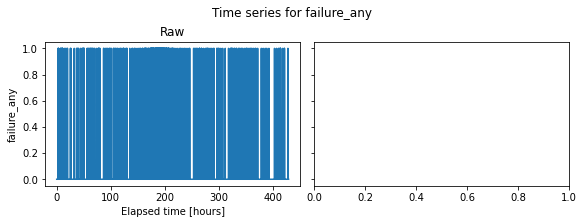

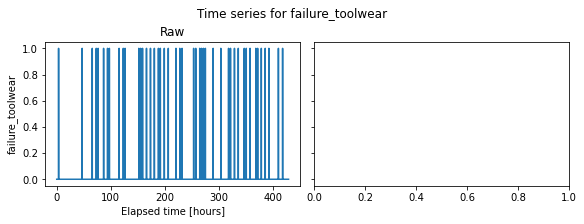

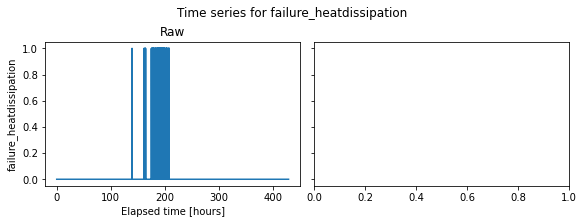

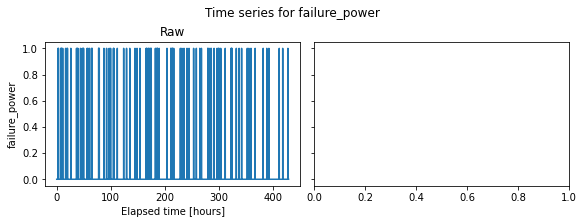

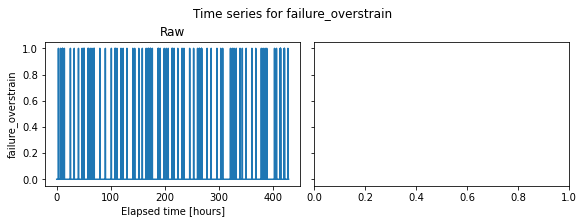

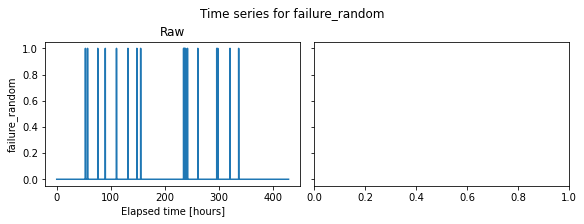

In [49]:
dfs, x = generate_plot_data(0, len(machine))
plot_multiple_time_series(dfs, x)

#### Multiple

Observations:
- The two temperatures correlate well.

Idea for future work:
- Check the coherence of the two signals. See [here](https://matplotlib.org/stable/gallery/lines_bars_and_markers/cohere.html#sphx-glr-gallery-lines-bars-and-markers-cohere-py) and [here](https://en.wikipedia.org/wiki/Coherence_(signal_processing)).
- Look for other methods / metrics.

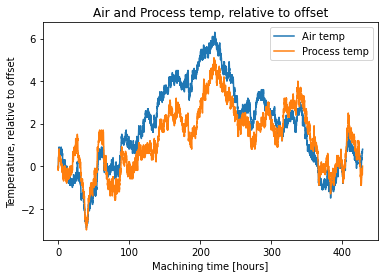

In [50]:
plt.plot(x, machine.air_temperature - machine.air_temperature[1], label="Air temp")
plt.plot(x, machine.process_temperature - machine.process_temperature[1], label="Process temp")

plt.title("Air and Process temp, relative to offset")
plt.xlabel("Machining time [hours]")
plt.ylabel("Temperature, relative to offset")
plt.legend()
plt.show()

In [51]:
# Correlations
pearson = machine[["air_temperature", "process_temperature"]].corr(method="pearson").iloc[0, 1]
spearman = machine[["air_temperature", "process_temperature"]].corr(method="spearman").iloc[0, 1]
pearson, spearman

(0.8761071581166568, 0.8642172381038954)

#### Tool replacements

Observations:
- Tool is replaced at roughly regular intervals, approx. 3.5 hours.
- No apparent relationship between failure occurrence and tool replacement.

In [52]:
all_failures = machine[machine.failure_any == 1].failure_any

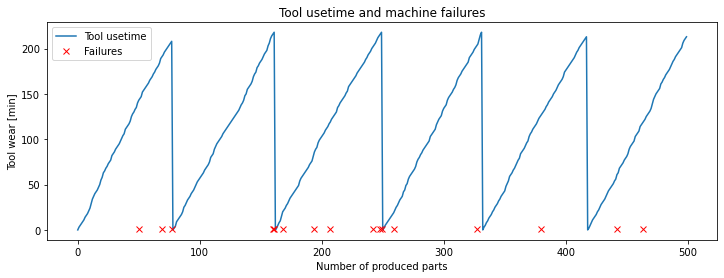

In [53]:
plt.figure(figsize=(12, 4))

plt.plot(machine.tool_wear[:500], label="Tool usetime")
plt.plot(all_failures[all_failures.index < 500], 'rx', label="Failures")

plt.xlabel("Number of produced parts")
plt.ylabel("Tool wear [min]")
plt.title("Tool usetime and machine failures")
plt.legend()
plt.show()

### Distributions
#### Histogram

Several plots for each variable, each with different number of bins to ensure objective observations.

Observations:
 - The two temperatures do not seem to be normally distributed.
 - `Torque` and `Speed `seem normally distributed.
 - `Speed` distibution is asymmetric with positive skew of ~2.

In [54]:
def plot_distribution_with_multiple_bins(df, variable, multiple_bins, width=4, height=3, density=True):
    """
    Plot a set of histograms for a variable with different number of bins.

    `width`: the width of a single plot
    `height`: the height of a single plot
    `density`: passed as the density parameter in the histogram function
    """
    ncols = len(multiple_bins)

    fig, axs = plt.subplots(
        nrows=1,
        ncols=ncols,
        constrained_layout=True,
        sharey=True,
        figsize=(ncols * width, height)
    )

    axs[0].set_ylabel(f"Frequency of {variable}")
    axs[0].set_xlabel("Count of parts")

    for bins, ax in zip(multiple_bins, axs):
        ax.hist(df[variable], bins=bins, density=density)

    fig.suptitle(f"Time series for {variable}", fontsize=12)

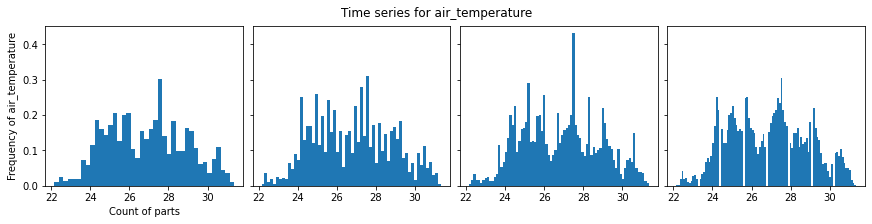

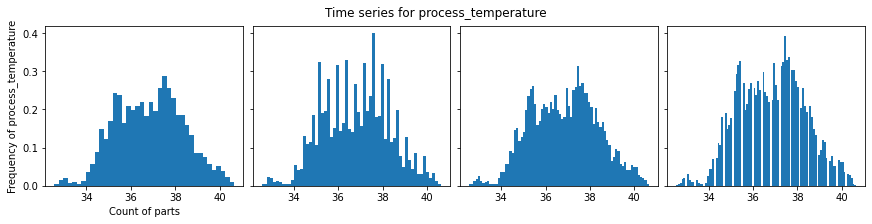

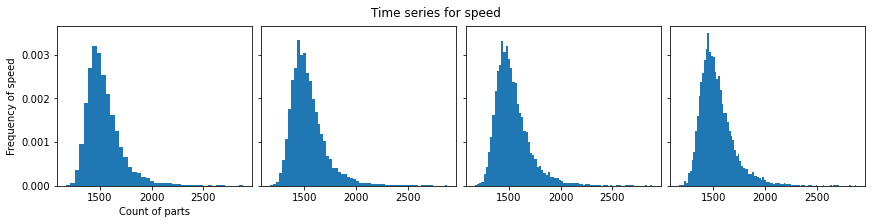

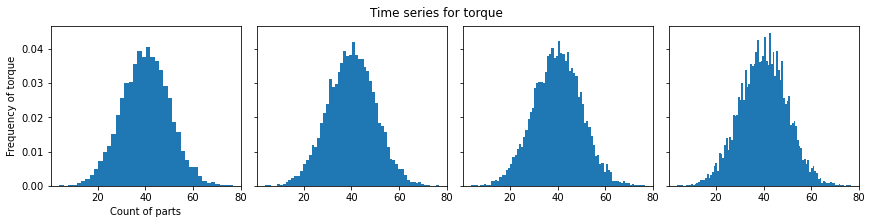

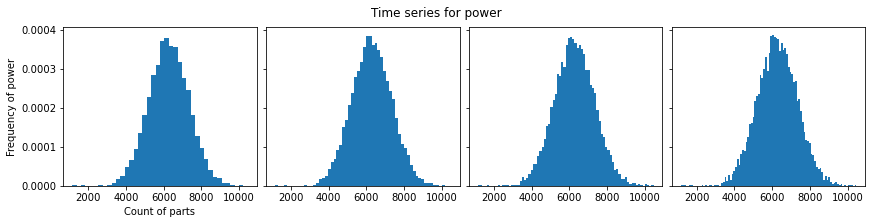

In [55]:
multiple_bins = [40, 60, 80, 100]

for variable in continuous_variables:
    plot_distribution_with_multiple_bins(
        df=machine,
        variable=variable,
        multiple_bins=multiple_bins,
        width=3,
        height=3
    )

In [56]:
# Skewness
machine[continuous_variables].skew()


air_temperature        0.114274
process_temperature    0.015027
speed                  1.993171
torque                -0.009517
power                  0.008257
dtype: float64

#### Boxplot

Data is normalized to be plotted on one plot.

Observations:
- The asymmetry in the distribution of `speed` is visible again.

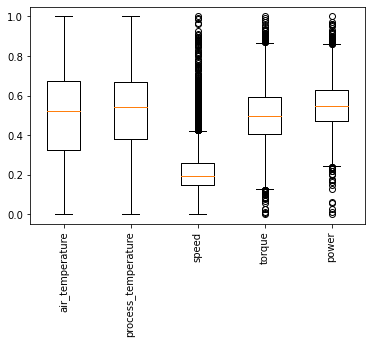

In [57]:
scaler = MinMaxScaler()
machine_continuous_variables_scaled = scaler.fit_transform(machine[continuous_variables])

plt.boxplot(machine_continuous_variables_scaled, labels=continuous_variables)
plt.xticks(rotation=90)
plt.show()

#### By product type

Observations:
- No apparent difference between the product types.

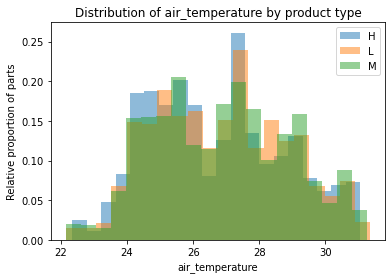

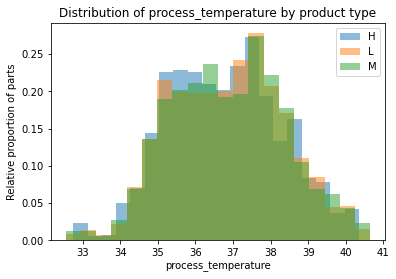

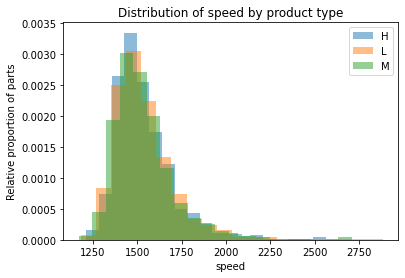

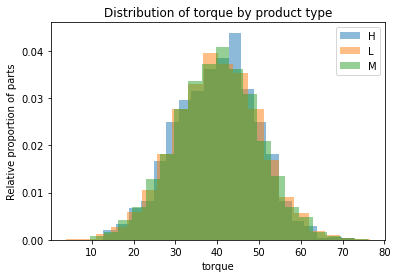

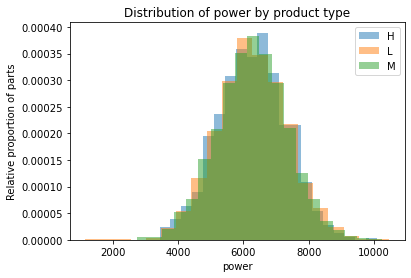

In [58]:
for variable in continuous_variables:
    for product_type, group_data in machine[[str(variable), "product_type"]].groupby("product_type"):
        data = group_data[variable]
        plt.hist(data, label=product_type, alpha=0.5, bins=20, density=True)
    
    plt.xlabel(variable)
    plt.ylabel("Relative proportion of parts")
    plt.title(f"Distribution of {variable} by product type")
    plt.legend()
    plt.show()

### Correlations

Clues:
 - Strong correlations between:
 any 2 out of `speed`, `power` and `torque`; `process_temp`-`air_temp`.
 - All the above make physical sense.
 - No other correlations.

In [59]:
machine_for_correlation = machine[variables_for_correlation]

pear_corr = machine_for_correlation.corr()
pear_corr_triangular = pear_corr.where(np.tril(np.ones(pear_corr.shape)).astype("bool"))

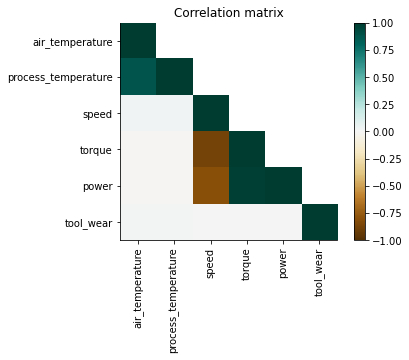

In [60]:
plt.imshow(pear_corr_triangular, cmap='BrBG', vmin=-1, vmax=1)
plt.colorbar()

ticks = np.arange(len(pear_corr_triangular))
labels = pear_corr_triangular.columns
plt.yticks(ticks, labels)
plt.xticks(ticks, labels, rotation='vertical')

ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.title("Correlation matrix")
plt.show()

## 4. Test hypotheses

We spotted no discrepancies in any of the group comparisons above. This is likely because the data set was generated artificially. No good real hypothesis can be tested. Let's perform a dummy test anyway and use it as template for any future insights that may arise. 

### Mean motor power

1. Parameters of interest: $\mu_L$, $\mu_M$, $\mu_H$ - the population means for each product type of the consumed motor power to machine a part
2. Null hypothesis: $H_0$: the population means are equal $\mu_L = \mu_M = \mu_H$
3. Alternative hypothesis $H_1$: the means are different
4. Reject $H_0$ if: Reject $H_0$ if the p-value is less then 0.05.
5. Conclusions: We fail to reject $H_0$ 
6. Practical interpretation: There is insufficient evidence to support the claim that the consumed power by the motor to machine a part is different per product type. 

In [61]:
power_by_product_type = machine.groupby("product_type").power

power_L = power_by_product_type.get_group("L")
power_M = power_by_product_type.get_group("M")
power_H = power_by_product_type.get_group("H")

In [62]:
st.f_oneway(power_L, power_M, power_H)

F_onewayResult(statistic=0.13950270083624441, pvalue=0.8697923672178566)

## 5. Model

Our **end objective** is to be able to predict when a machine failure would occur based on the sensor inputs that we would measure. To make such prediction we create a mathematical model using the available data. When given input data, the model would output one of two statements: 0 = "Machine functions normally" or 1 = "There is failure!". In ML, the term used for the set of output options is "classes". The type of algorithm that predicts such discrete class is called "classification algorithm". One of the simplest types of classification algorithms is the logistic regression.

Lets create **several models** using different set of features (also called predictors in the context of modeling). A logical expectation is that using less features would worsen the model predictions. We need a number, a **scoring metric** to compare the performances: the typical for a classification model is accuracy (= the proportion of correct predictions out of all guesses).

At first glance, the accuracy of the first model is great - 97%. Surprisingly however, it hardly changes when the set of features is modified. Why? If we think a little deeper, the original data has really low number of failures (3.4%). If can always guess 0 (= no failure) and its accuracy would be high. The cause of what we see is this low number of the failure class.

This issue is common and is given a name: **imbalanced classes** (see [post](https://stats.stackexchange.com/a/168946)). There are [tactics](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/) to cope with such data sets. Let's investigate those in future.

In [63]:
def model_data(columns_for_modeling):
    # Filter columns
    machine_for_modeling = machine[columns_for_modeling]

    # Add indicator variables
    machine_for_modeling = pd.get_dummies(
        machine_for_modeling, columns=["product_type"])

    # Divide into features and target
    target_column = "failure_any"
    machine_features = machine_for_modeling.drop(columns=target_column)
    machine_target = machine_for_modeling[target_column]

    # Normalize the data
    scaler = MinMaxScaler()
    machine_features_scaled = scaler.fit_transform(machine_features)

    # Split to train and test data
    features_train, features_test, target_train, target_test = train_test_split(
        machine_features_scaled, machine_target, train_size=0.7, test_size=0.3, random_state=42)
    print("Train data shapes: ", features_train.shape, target_train.shape)
    print("Test data shapes: ", features_test.shape, target_test.shape)

    # Fit Logistic Regression model
    model = LogisticRegression().fit(features_train, target_train)

    # Score the model with test data
    score = model.score(features_test, target_test)
    print(f"Score: {score}")

In [64]:
columns_for_modeling = [
    "product_type",
    "air_temperature",
    "process_temperature",
    "speed",
    "power",
    "torque",
    "tool_wear",
    "failure_any",
]

model_data(columns_for_modeling)

Train data shapes:  (7000, 9) (7000,)
Test data shapes:  (3000, 9) (3000,)
Score: 0.9693333333333334


In [65]:
columns_for_modeling = [
    "product_type",
    "air_temperature",
    "process_temperature",
    "speed",
    # "power",
    "torque",
    "tool_wear",
    "failure_any",
]

model_data(columns_for_modeling)

Train data shapes:  (7000, 8) (7000,)
Test data shapes:  (3000, 8) (3000,)
Score: 0.969


In [66]:
columns_for_modeling = [
    "product_type",
    "air_temperature",
    "process_temperature",
    # "speed",
    # "power",
    # "torque",
    "tool_wear",
    "failure_any",
]

model_data(columns_for_modeling)

Train data shapes:  (7000, 6) (7000,)
Test data shapes:  (3000, 6) (3000,)
Score: 0.969


Check model coefficients

In [67]:
# print("Model coefficients:")
# for column, coef in zip(machine_features.columns, list(*model.coef_)):
#     print(f"{column}: {coef.round(2)}")

Predict single records and compare

In [68]:
# for x in np.random.randint(0, len(target_test), 20):
#     random_input = features_test[x,:].reshape(1, -1)
#     random_response = target_test.iloc[x]
#     expected = model.predict(random_input)[0]
#     print(f"index: {x}, expected: {expected}, actual: {random_response}")

Go to part 2...